<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Dataset

## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data

In [8]:
data_march = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211002/주문3월.csv", low_memory=False)
data_april = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-2. 이커머스 FC주문 데이터_4월.csv", low_memory=False)
data_may = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-3. 이커머스 FC주문 데이터_5월.csv", low_memory=False)
data_june = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-4. 이커머스 FC주문 데이터_6월.csv", low_memory=False)

In [9]:
def make_lstm_data():
  data = [data_march, data_april, data_may, data_june]
  month_name = ['march', 'april', 'may', 'june']
  date = [[],[],[],[]]
  date_per_qty = [[],[],[],[]]
  order_date = [[],[],[],[]]

  date[0] = sorted(data_march.BKG_DATE.unique())
  date[1] = sorted(data_april.BKG_DATE.unique())
  date[2] = sorted(data_may.BKG_DATE.unique())
  date[3] = sorted(data_june.BKG_DATE.unique())
  
  date_dic = [{},{},{},{}]
  for idx, mn in enumerate(month_name):
    for d in date[idx]:
      date_dic[idx][d] = sum(data[idx].loc[(data[idx].BKG_DATE == d)].ITEM_QTY)

  for idx in range(len(date_dic)):
    date_per_qty[idx] = list(date_dic[idx].values())
    order_date[idx] = list(date_dic[idx].keys())
  
  result = pd.DataFrame(order_date[0],columns=['주문날짜'])
  result['일별수량'] = date_per_qty[0]

  for idx in range(1,4):
    tmp = pd.DataFrame(order_date[idx],columns=['주문날짜'])
    tmp['일별수량'] = date_per_qty[idx]
    result = pd.concat([result,tmp], axis=0)
  
  result = result.reset_index().drop('index',axis=1)
  # lstm_y = result.일별수량
  # lstm_x = result.set_index('주문날짜')
  # print(lstm_y)
  # print(lstm_x)
  return result
  
lstm_data = make_lstm_data()
lstm_data

,주문날짜,일별수량
0,20210301,11197
1,20210302,17655
2,20210303,17322
3,20210304,13203
4,20210305,24565
...,...,...
117,20210626,20186
118,20210627,25808
119,20210628,40704
120,20210629,29409


In [ ]:
training_set = lstm_data.일별수량.values
training_set = training_set.reshape(-1,1)
training_set

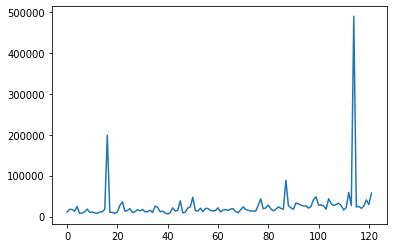

In [19]:
plt.plot(training_set, label = 'Data')
plt.show()

## Dataloading

In [13]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [15]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02021
Epoch: 100, loss: 0.00204
Epoch: 200, loss: 0.00204
Epoch: 300, loss: 0.00203
Epoch: 400, loss: 0.00203
Epoch: 500, loss: 0.00202
Epoch: 600, loss: 0.00202
Epoch: 700, loss: 0.00200
Epoch: 800, loss: 0.00199
Epoch: 900, loss: 0.00197
Epoch: 1000, loss: 0.00195
Epoch: 1100, loss: 0.00193
Epoch: 1200, loss: 0.00191
Epoch: 1300, loss: 0.00184
Epoch: 1400, loss: 0.00174
Epoch: 1500, loss: 0.00177
Epoch: 1600, loss: 0.00193
Epoch: 1700, loss: 0.00190
Epoch: 1800, loss: 0.00189
Epoch: 1900, loss: 0.00189


## Testing for Shampoo Sales Dataset

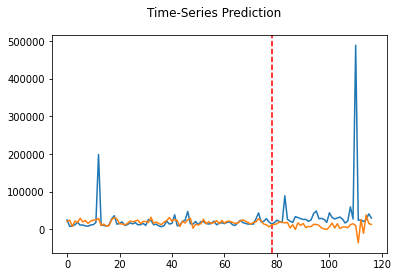

In [16]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Testing for Airplane Passengers Dataset

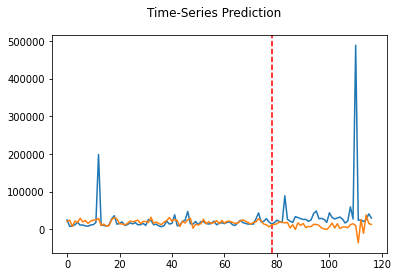

In [17]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()